In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds

using Gen
import GenPOMDPs
import GenParticleFilters
const GPF = GenParticleFilters

using GenSMCP3

# We need this to help with dualizing and undualizing values...
const DFD = GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


DynamicForwardDiff

In [53]:
(_segs, _bb, _center) = L.load_env_sparse("../../data/environments", 2)

(_segs = LineWorlds.Geometry.Segment[LineWorlds.Geometry.Segment([0.11, 0.1], [0.1, 0.11]), LineWorlds.Geometry.Segment([0.1, 0.11], [0.1, 5.07]), LineWorlds.Geometry.Segment([0.1, 5.07], [1.51, 5.07]), LineWorlds.Geometry.Segment([1.51, 5.07], [1.52, 5.08]), LineWorlds.Geometry.Segment([1.52, 5.08], [1.52, 5.18]), LineWorlds.Geometry.Segment([1.52, 5.18], [1.51, 5.19]), LineWorlds.Geometry.Segment([1.51, 5.19], [0.1, 5.19]), LineWorlds.Geometry.Segment([0.1, 5.19], [0.1, 11.26]), LineWorlds.Geometry.Segment([0.1, 11.26], [5.07, 11.26]), LineWorlds.Geometry.Segment([5.07, 11.26], [5.07, 9.76])  …  LineWorlds.Geometry.Segment([13.23, 5.08], [13.24, 5.07]), LineWorlds.Geometry.Segment([13.24, 5.07], [14.26, 5.07]), LineWorlds.Geometry.Segment([14.26, 5.07], [14.26, 0.1]), LineWorlds.Geometry.Segment([14.26, 0.1], [10.29, 0.1]), LineWorlds.Geometry.Segment([10.29, 0.1], [10.29, 0.7]), LineWorlds.Geometry.Segment([10.29, 0.7], [10.28, 0.71]), LineWorlds.Geometry.Segment([10.28, 0.71], [10.

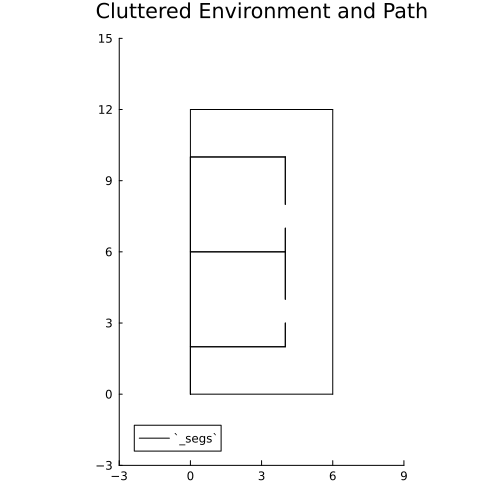

In [55]:
# (_segs, _bb, _center) = L.load_env_sparse("../../data/environments", 8)
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json")

mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)

plot!(_segs, c=:black, label="`_segs`")

In [56]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [68]:
tr = let L = 15
        generate(trajectory_model, (
                L,
                [:stay, :stay, :stay, :stay, :right,
                :right, :right, :up, :up, :up,
                :up, :stay, :stay, :stay, :stay],
                PARAMS,
            ), choicemap((GenPOMDPs.state_addr(0, :pos), [2., 4.0]))
        )[1];
end

GenPOMDPs.var"##StaticIRTrace__ControlledTrajectoryModel#1086"(15, [:stay, :stay, :stay, :stay, :right, :right, :right, :up, :up, :up, :up, :stay, :stay, :stay, :stay], (map = LineWorlds.Geometry.Segment[LineWorlds.Geometry.Segment([0.0, 0.0], [6.0, 0.0]), LineWorlds.Geometry.Segment([6.0, 0.0], [6.0, 12.0]), LineWorlds.Geometry.Segment([6.0, 12.0], [0.0, 12.0]), LineWorlds.Geometry.Segment([0.0, 12.0], [0.0, 0.0]), LineWorlds.Geometry.Segment([0.0, 0.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [4.0, 3.0]), LineWorlds.Geometry.Segment([4.0, 3.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [0.0, 6.0])  …  LineWorlds.Geometry.Segment([4.0, 6.0], [4.0, 7.0]), LineWorlds.Geometry.Segment([4.0, 7.0], [4.0, 6.0]), LineWorlds.Geometry.Segment([4.0, 6.0], [0.0, 6.0]), LineWorlds.Geometry.Segment([0.0, 6.0], [0.0, 10.0]), LineWorlds.Geometry.Segment([0.0, 10.0], [4.0,

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_RWb4xS96Ts.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_RWb4xS96Ts.gif")
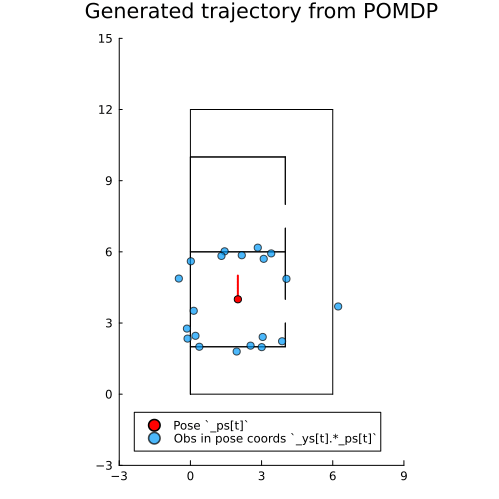

In [69]:
using Random
# -----------------------
let
    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];
    # -----------------------
    col = palette(:default)
    ani = Animation()
    for t=1:1:length(poses)
        p = poses[t]
        y = ptclouds[t]

        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
            xlim=(_bb[1][1]-3, _bb[2][1]+3),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, label="Pose `_ps[t]`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

        frame(ani, agent_plt)
    end
    # gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
    gif(ani, fps=3)
end

In [50]:
includet("06_src.jl")

In [70]:
_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [.5, .5] # size of grid cells at first iteration
    ),
    n_iters = 3 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    n_iters=5, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[9, 9], r=[2., 2.]),
    initial_pos = [9.5, 9.5] # center of grid for first timestep
)

(tau = 1.0, pmin = 1.0e-6, init_grid_args = (k = [9, 9], r = [2.0, 2.0]), n_iters = 5, initial_pos = [9.5, 9.5])

In [98]:
pf = @get_pf(PARAMS, _grid_args, _t0_grid_args);

In [101]:
states = run_inference(tr, pf);

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_1yxuNqLgR8.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_1yxuNqLgR8.gif")
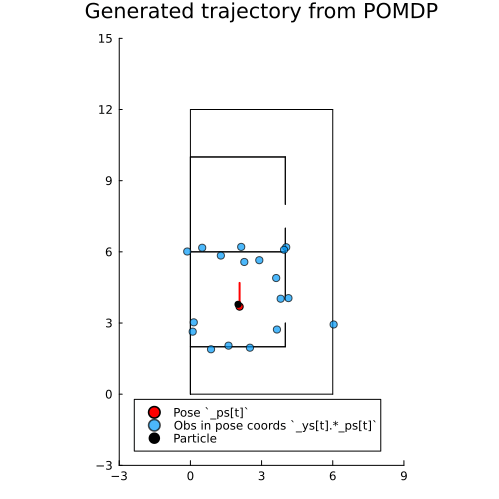

In [102]:
let

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=1:length(states)-2
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
            xlim=(_bb[1][1]-3, _bb[2][1]+3),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, label="Pose `_ps[t]`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    
        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label="Particle")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    # gif(ani, "smcp3_coarse_to_fine.gif", fps=1) # gif(ani, fname, fps=10)
    gif(ani, fps=1)
end